In [1]:
from utils.data_utils import load_dataset, save_dataset
from utils.functions import load_problem
from utils import load_model
import torch
import numpy as np
torch.manual_seed(1235)

In [2]:
problem = load_problem('tsp')

In [3]:
reviser_path = 'pretrained_LCP/constructions/Reviser-6-scale/reviser_100/epoch-400.pt'
reviser, _ = load_model(reviser_path, is_local=True)
reviser.eval()
reviser.set_decode_type("greedy")

  [*] Loading model from pretrained_LCP/constructions/Reviser-6-scale/reviser_100/epoch-400.pt


In [4]:
# dataset = reviser.problem.make_dataset(filename='data/FI_train_tsp/500_FI100_seed1235.pkl', num_samples=1000000, offset=0)

In [5]:
# from torch.utils.data import DataLoader
# dataloader = DataLoader(dataset, batch_size=500)

In [4]:
def get_cost(seed):
    ret = (seed[:, 1:] - seed[:, :-1]).norm(p=2, dim=2).sum(1) + (seed[:, 0] - seed[:, -1]).norm(p=2, dim=1)
    return ret

In [5]:
def coordinate_transform(decomposed_seeds):    
    # coordinate transformation
    max_x, indices_max_x = decomposed_seeds[:,:,0].max(dim=1)
    max_y, indices_max_y = decomposed_seeds[:,:,1].max(dim=1)
    min_x, indices_min_x = decomposed_seeds[:,:,0].min(dim=1)
    min_y, indices_min_y = decomposed_seeds[:,:,1].min(dim=1)
    # shapes: (batch_size, ); (batch_size, )
    
    diff_x = max_x - min_x
    diff_y = max_y - min_y
    xy_exchanged = diff_y > diff_x

    # shift to zero
    decomposed_seeds[:, :, 0] -= (min_x).unsqueeze(-1)
    decomposed_seeds[:, :, 1] -= (min_y).unsqueeze(-1)

    # exchange coordinates for those diff_y > diff_x
    decomposed_seeds[xy_exchanged, :, 0], decomposed_seeds[xy_exchanged, :, 1] =  decomposed_seeds[xy_exchanged, :, 1], decomposed_seeds[xy_exchanged, :, 0]
    
    # scale to (0, 1)
    scale_degree = torch.max(diff_x, diff_y)
    scale_degree = scale_degree.view(decomposed_seeds.shape[0], 1, 1)
    decomposed_seeds /= scale_degree

    return decomposed_seeds
    # transformation done


In [19]:
from tqdm import tqdm
import torch
from utils.functions import revision, decomposition
import copy

original_subtour = torch.arange(100)

get_cost_func = lambda input, pi: problem.get_costs(input, pi, return_local=True)

RG_dataset = []
for dataset_id in range(1):
    print(dataset_id)
    
    for batch in tqdm(range(2)): # 2000
        seeds200 = torch.rand(size=(25, 200, 2))
        seeds1000 = torch.rand(size=(5, 1000, 2))
        offset = 0


        decomposed_seeds, offset_seed = decomposition(
                                    seeds200, 
                                    coordinate_dim=2,
                                    revision_len=100,
                                    offset = offset,
                                    shift_len = 0
                                    )
        decomposed_seeds2, offset_seed = decomposition(
                                seeds200, 
                                coordinate_dim=2,
                                revision_len=100,
                                offset = offset,
                                shift_len = 0
                                )
        decomposed_seeds = torch.cat((decomposed_seeds, decomposed_seeds2), dim=0)

        original_subtour = torch.arange(0, 100, dtype=torch.long)
        for _ in range(10):
            decomposed_seeds = revision(get_cost_func, reviser, decomposed_seeds, original_subtour)
            decomposed_seeds, offset_seed = decomposition(
                                decomposed_seeds, 
                                coordinate_dim=2,
                                revision_len=100,
                                offset = offset,
                                shift_len = 10
                                )

        decomposed_seeds = coordinate_transform(decomposed_seeds)


        print('cost: \n', get_cost(decomposed_seeds))
        RG_dataset.extend(decomposed_seeds.numpy().tolist())
        # print(len(RG_dataset))

    # save_dataset(RG_dataset, f'./data/RG/RG100_{dataset_id}.pkl')


0


 50%|█████     | 1/2 [00:04<00:04,  4.69s/it]

cost: 
 tensor([8.0100, 7.5835, 8.3188, 8.5279, 7.8863, 8.6557, 8.1934, 8.1496, 8.1163,
        8.3623, 8.4628, 8.5061, 8.4174, 8.1139, 8.6118, 8.4492, 8.3801, 8.3723,
        7.8638, 8.0336, 8.3236, 8.0206, 8.2394, 7.9712, 8.2338, 7.9494, 8.7341,
        8.2023, 8.1134, 8.2805, 7.9651, 7.8200, 8.2485, 8.3910, 8.0188, 8.3378,
        8.0699, 7.7854, 8.0582, 7.9837, 7.8247, 8.3284, 7.7672, 8.6375, 8.5738,
        8.3216, 7.7873, 7.5742, 8.5264, 8.5613, 8.0100, 7.5835, 8.3188, 8.5279,
        7.8863, 8.6557, 8.1934, 8.1496, 8.1163, 8.3623, 8.4628, 8.5061, 8.4174,
        8.1139, 8.6118, 8.4492, 8.3801, 8.3723, 7.8638, 8.0336, 8.3236, 8.0206,
        8.2394, 7.9712, 8.2338, 7.9494, 8.7341, 8.2023, 8.1134, 8.2805, 7.9651,
        7.8200, 8.2485, 8.3910, 8.0188, 8.3378, 8.0699, 7.7854, 8.0582, 7.9837,
        7.8247, 8.3284, 7.7672, 8.6375, 8.5738, 8.3216, 7.7873, 7.5742, 8.5264,
        8.5613])


100%|██████████| 2/2 [00:09<00:00,  4.64s/it]

cost: 
 tensor([8.4687, 8.2879, 7.7325, 8.0917, 8.1411, 8.3169, 7.6470, 8.3511, 9.0156,
        8.3215, 8.0486, 8.2873, 8.2367, 8.2048, 8.1200, 8.4029, 8.5520, 8.6527,
        8.2704, 8.3537, 8.2011, 8.6931, 8.5225, 8.3242, 8.0983, 8.0324, 8.7205,
        8.5043, 7.8775, 8.3269, 7.4730, 7.9628, 8.2985, 8.4742, 8.6852, 8.1424,
        8.0645, 8.5744, 8.4930, 8.1013, 7.6362, 8.2820, 8.0967, 8.1031, 7.8540,
        8.1505, 8.3435, 8.1761, 7.5190, 8.0398, 8.4687, 8.2879, 7.7325, 8.0917,
        8.1411, 8.3169, 7.6470, 8.3511, 9.0156, 8.3215, 8.0486, 8.2873, 8.2367,
        8.2048, 8.1200, 8.4029, 8.5520, 8.6527, 8.2704, 8.3537, 8.2011, 8.6931,
        8.5225, 8.3242, 8.0983, 8.0324, 8.7205, 8.5043, 7.8775, 8.3269, 7.4730,
        7.9628, 8.2985, 8.4742, 8.6852, 8.1424, 8.0645, 8.5744, 8.4930, 8.1013,
        7.6362, 8.2820, 8.0967, 8.1031, 7.8540, 8.1505, 8.3435, 8.1761, 7.5190,
        8.0398])


<function matplotlib.pyplot.show(close=None, block=None)>

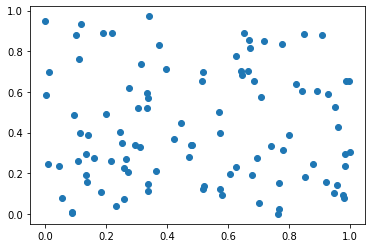

In [18]:
import matplotlib.pyplot as plt
import numpy as np
a = 12
plt.scatter(np.array(RG_dataset)[a, :, 0], np.array(RG_dataset)[a, :, 1])
plt.show

In [33]:
save_dataset(RG_dataset, './TEST.pkl')

In [23]:
RG_dataset[0][0]

[0.6815947890281677, 0.8329905271530151]